# 0.0 Imports

In [81]:
from scipy import stats
from IPython.display import display, HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import seaborn as sns
import numpy as np
import math
import pandas as pd
import inflection

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv ('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 Descricao dos dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old =['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore ( x )

cols_new = list(map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
print( 'Number of Rows: {}'.format(df1.shape[0] ) )
print( 'Number of Cols: {}'.format(df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply ( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan ( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan ( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week               508031
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan ( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan ( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval                  508031
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna( 0,inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [14]:
df1.sample(5).T

,242516,1000520,370507,492306,940520
store,628,36,504,262,246
day_of_week,4,2,7,3,7
date,2014-12-25 00:00:00,2013-01-15 00:00:00,2014-08-10 00:00:00,2014-04-16 00:00:00,2013-03-10 00:00:00
sales,0,7832,0,22128,0
customers,0,1009,0,3603,0
open,0,1,0,1,0
promo,0,0,0,1,0
state_holiday,c,0,0,0,0
school_holiday,1,0,1,0,0
store_type,a,a,c,b,c


## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion -std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']



In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


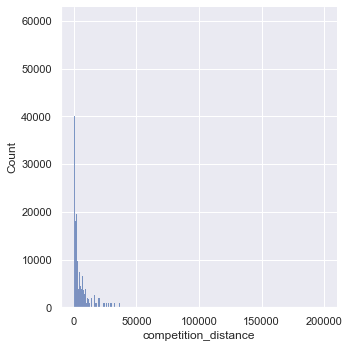

In [21]:
sns.displot(df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

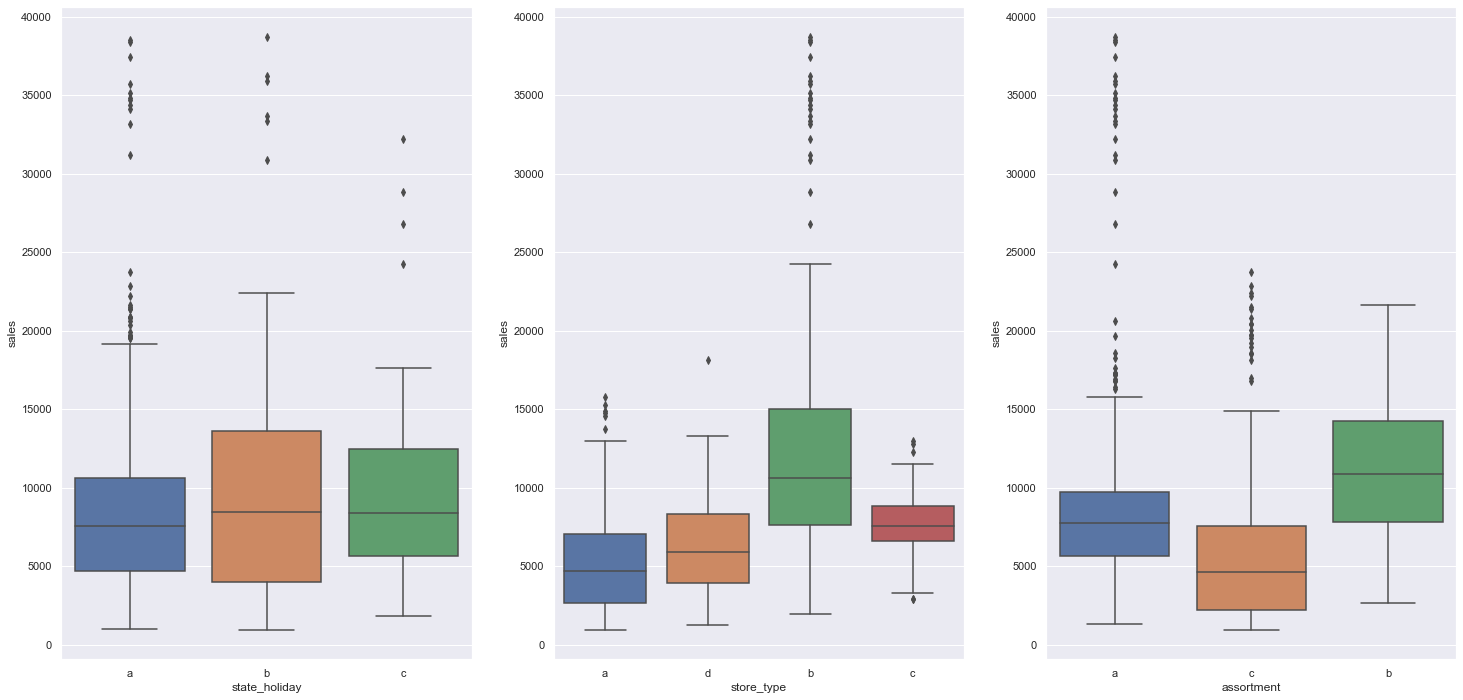

In [23]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday',y='sales',data=aux1 )


plt.subplot(1,3,2)
sns.boxplot( x='store_type',y='sales',data=aux1 )

plt.subplot(1,3,3)
sns.boxplot( x='assortment',y='sales',data=aux1 )

# 2.0 Criacao de Hipoteses

### 2.0.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais.

**1.** Lojas com competidores mais proximos deveriam vender menos.

**1.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.0.2 Hipotese Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem o precos menores deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

#### 2.0.3 Hipotese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longos dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.1 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longos dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [24]:
df2 = df1.copy()

In [25]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['year_of_week'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply(lambda x: x.days).astype( np.int64 )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta ( days=7 ) )
df2['promo_week'] = ( (df2['date'] - df2['promo_since'] ) /7).apply(lambda x: x.days ).astype( np.int64 )

# assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extented')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas_holiday' if x == 'c' else 'regular_day')

C:\Users\Vinicius\AppData\Local\Temp\ipykernel_8048\3478255165.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['year_of_week'] = df2['date'].dt.weekofyear


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,year_of_week,year_week,competition_since,competition_time_month,promo_since,promo_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extented,620.00,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [29]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]

In [30]:
## 3.2 Selecao das Colunas

In [31]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'year_of_week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_week'],
      dtype='object')

# 4.0 Analise Exploratoria dos Dados

In [33]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

C:\Users\Vinicius\anaconda3\envs\datascienceemproducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

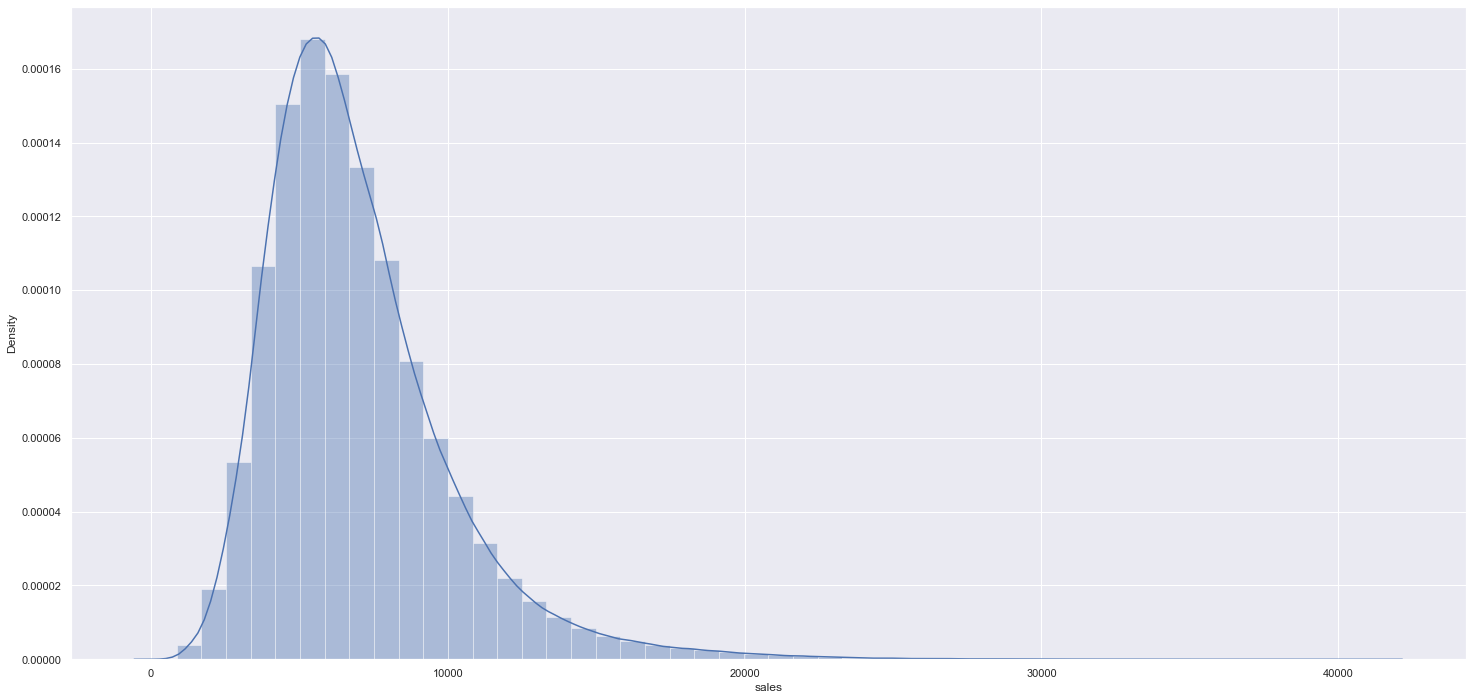

In [34]:
sns.distplot( df4['sales'] )

### 4.1.2 Numerical Variable

C:\Users\Vinicius\anaconda3\envs\datascienceemproducao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


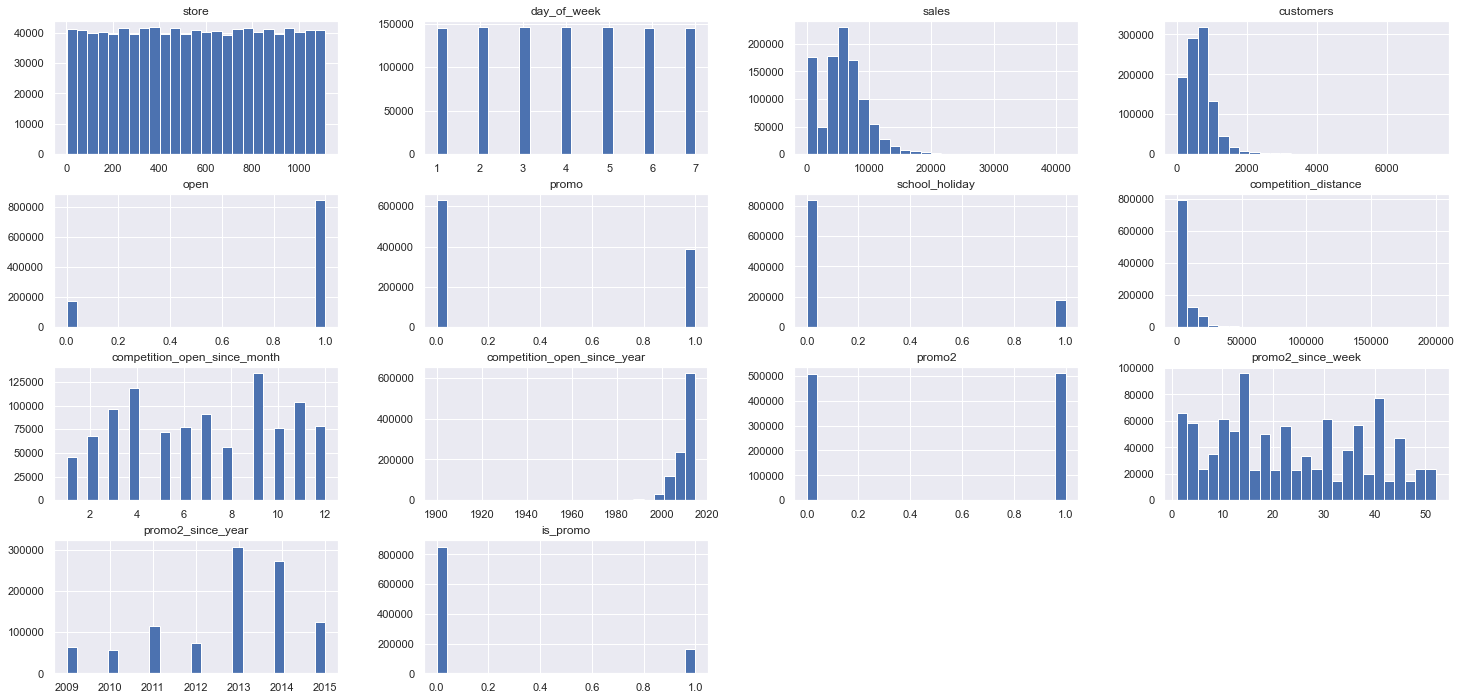

In [35]:
num_attributes.hist( bins=25);

### 4.1.1 Categorical Variable

In [36]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [37]:
df4['state_holiday'].drop_duplicates()

0               regular_day
63559        public_holiday
129424       easter_holiday
241126    christmas_holiday
Name: state_holiday, dtype: object

C:\Users\Vinicius\anaconda3\envs\datascienceemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

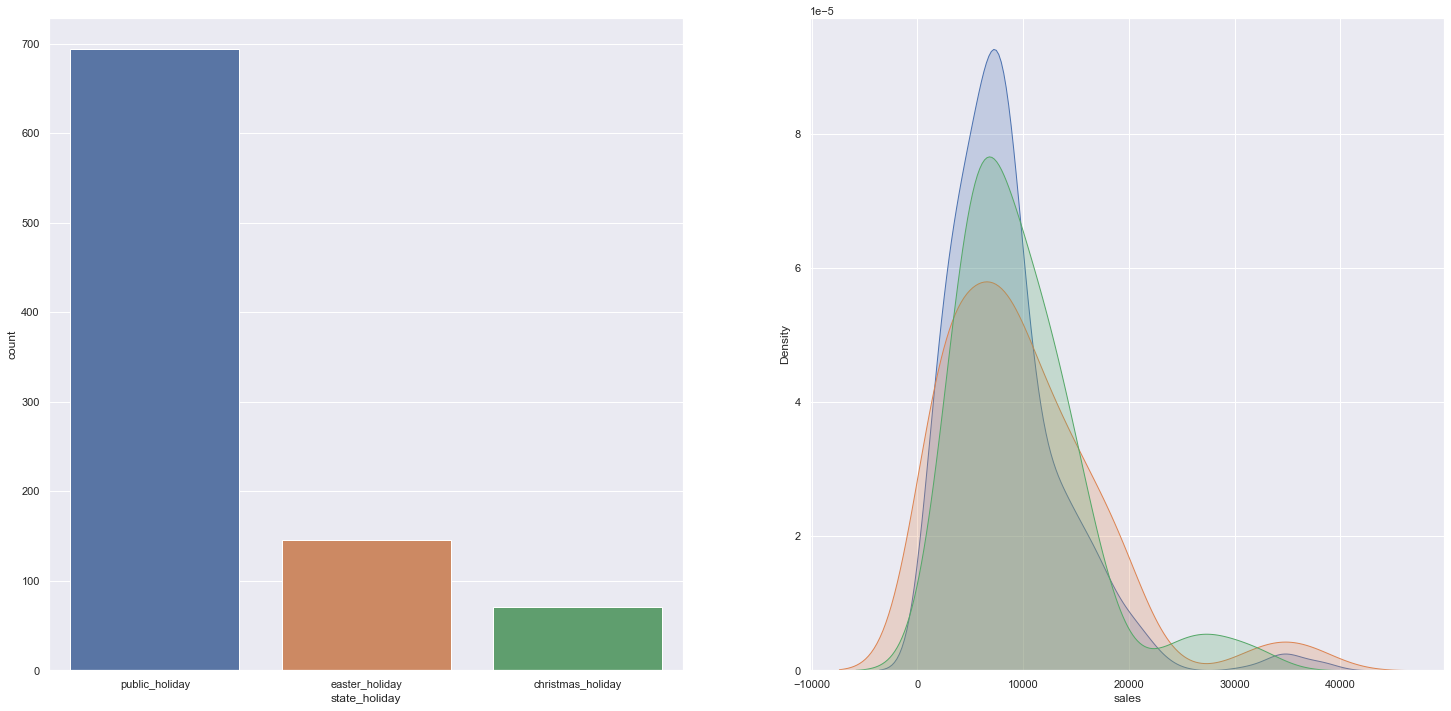

In [38]:
#state_holiday
plt.subplot(1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot(1,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label='christmas_holiday',shade=True)

In [39]:
#store_type
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

C:\Users\Vinicius\anaconda3\envs\datascienceemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

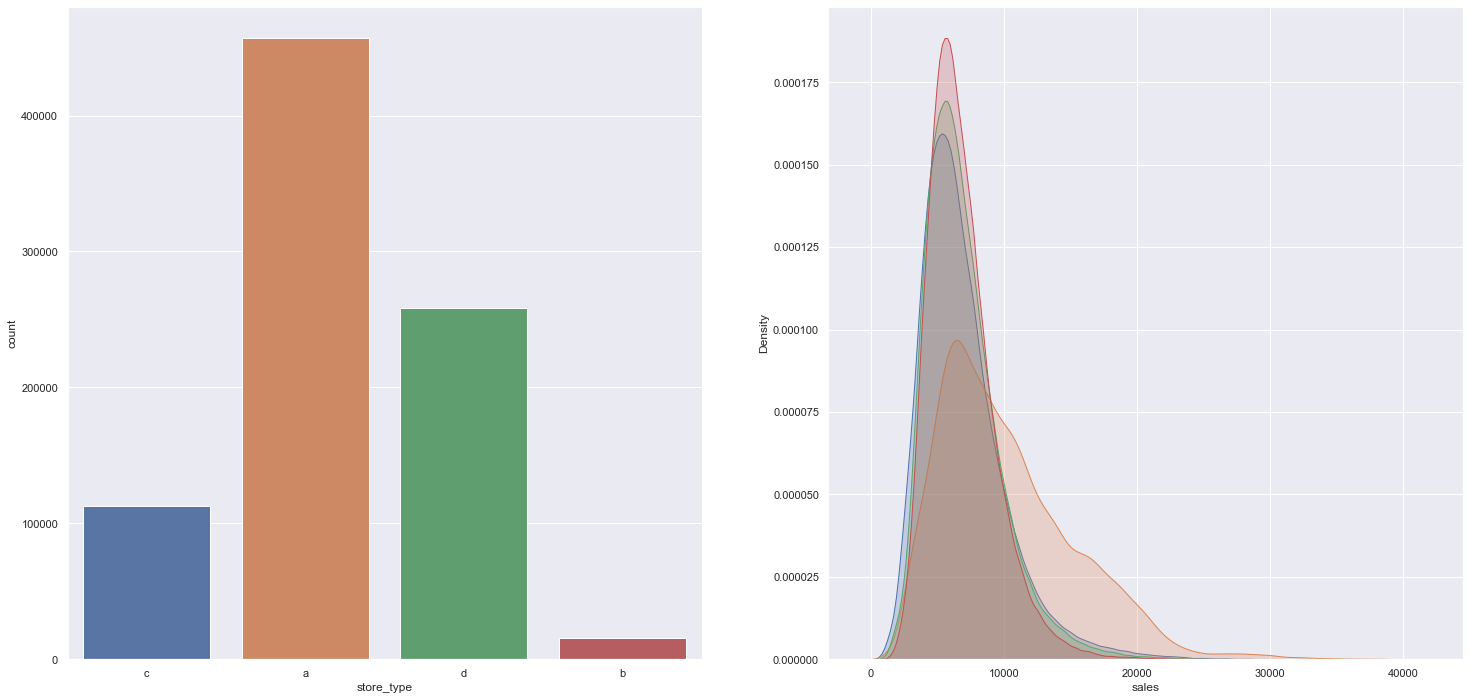

In [40]:
plt.subplot(1,2,1)

sns.countplot( df4['store_type'] )
plt.subplot(1,2,2)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)

C:\Users\Vinicius\anaconda3\envs\datascienceemproducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

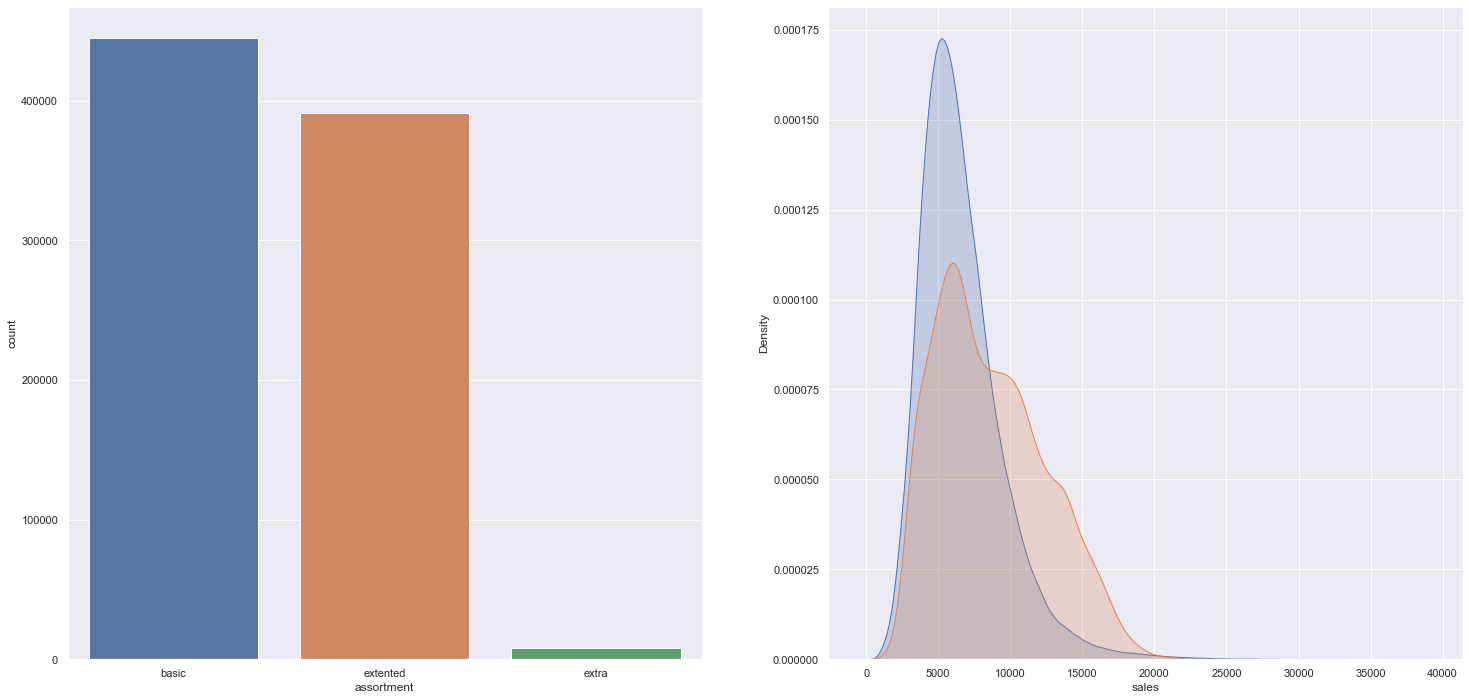

In [41]:
#assortment
plt.subplot(1,2,1)

sns.countplot( df4['assortment'] )
plt.subplot(1,2,2)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basci',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)

## 4.2 Analise Bivariada

### H1 Lojas com maior sortimentos deveriam vender mais.
***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS.

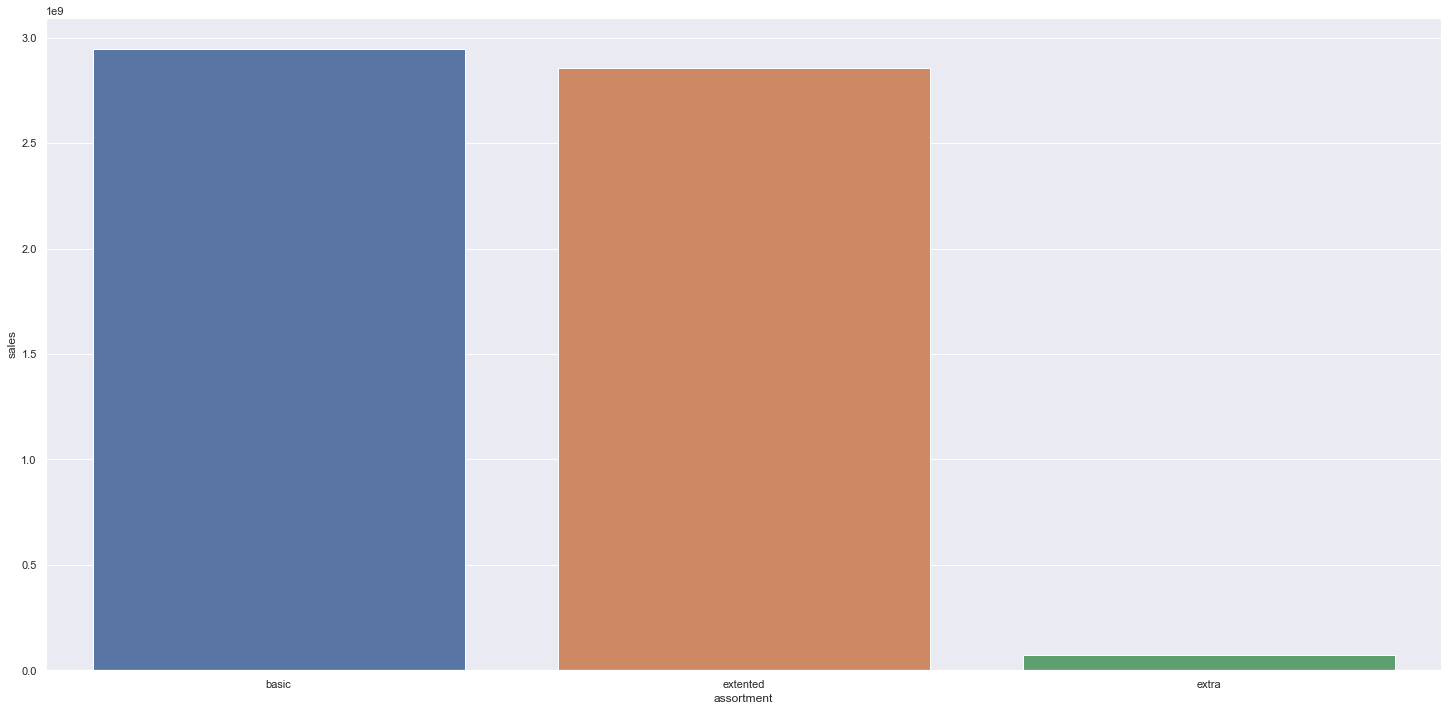

In [42]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

<AxesSubplot:xlabel='year_week'>

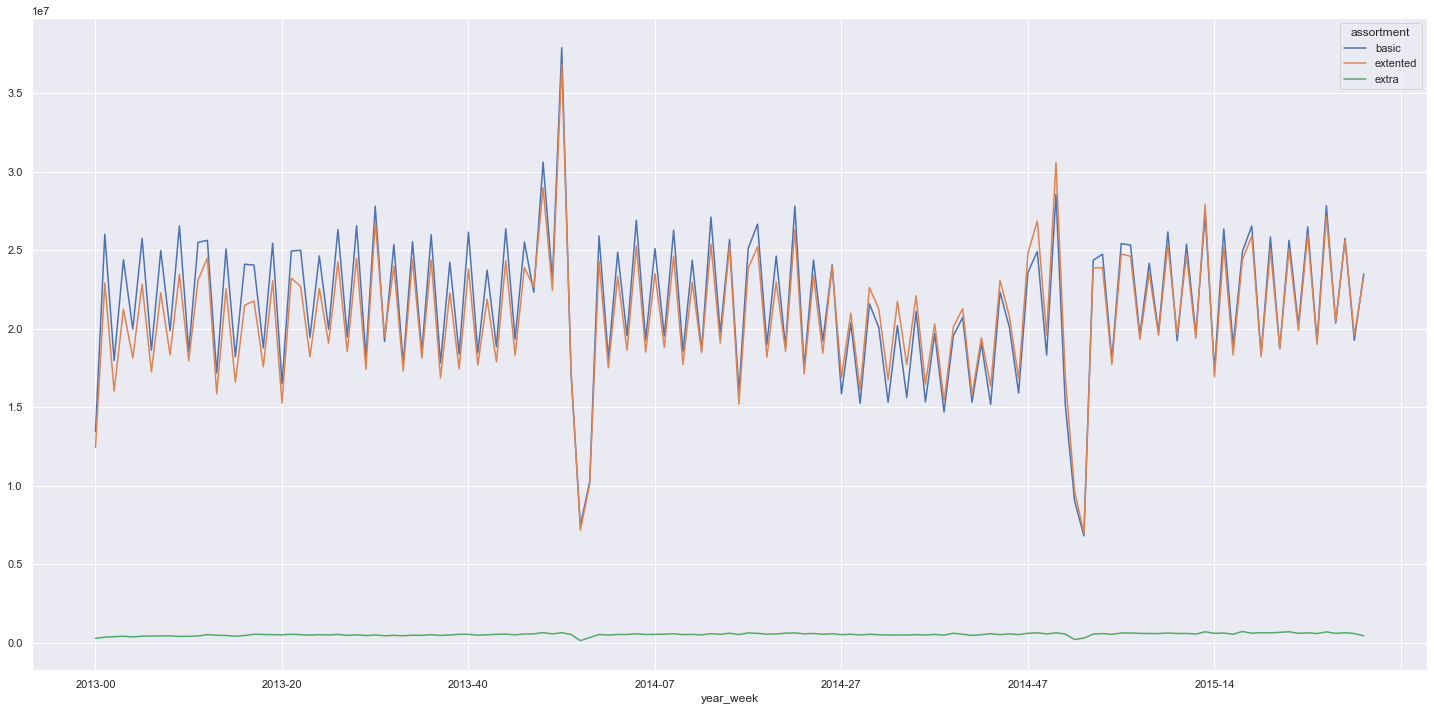

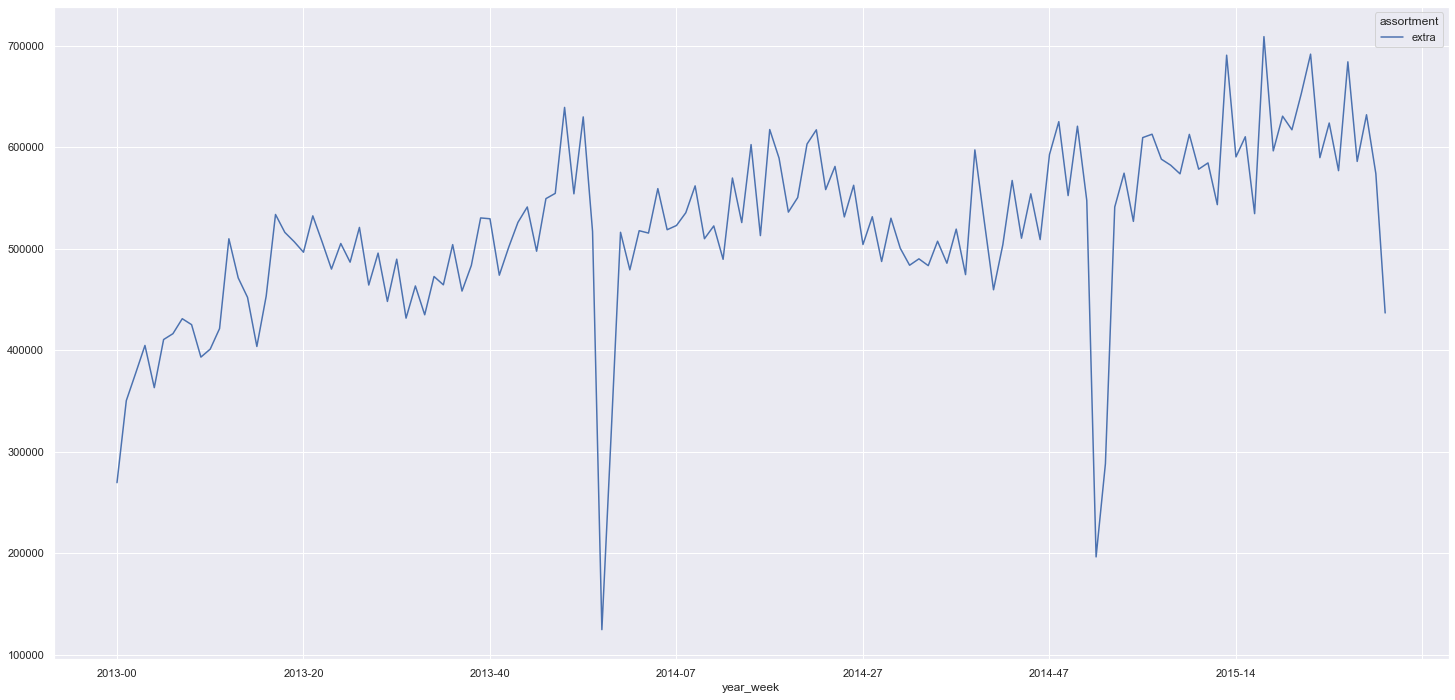

In [43]:
aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week',columns='assortment',values='sales').plot()

### H2 Lojas com competidores mais proximos deveriam vender menos.
***FALSA*** Lojas com competidores MAIS PROXIMOS vendem MAIS

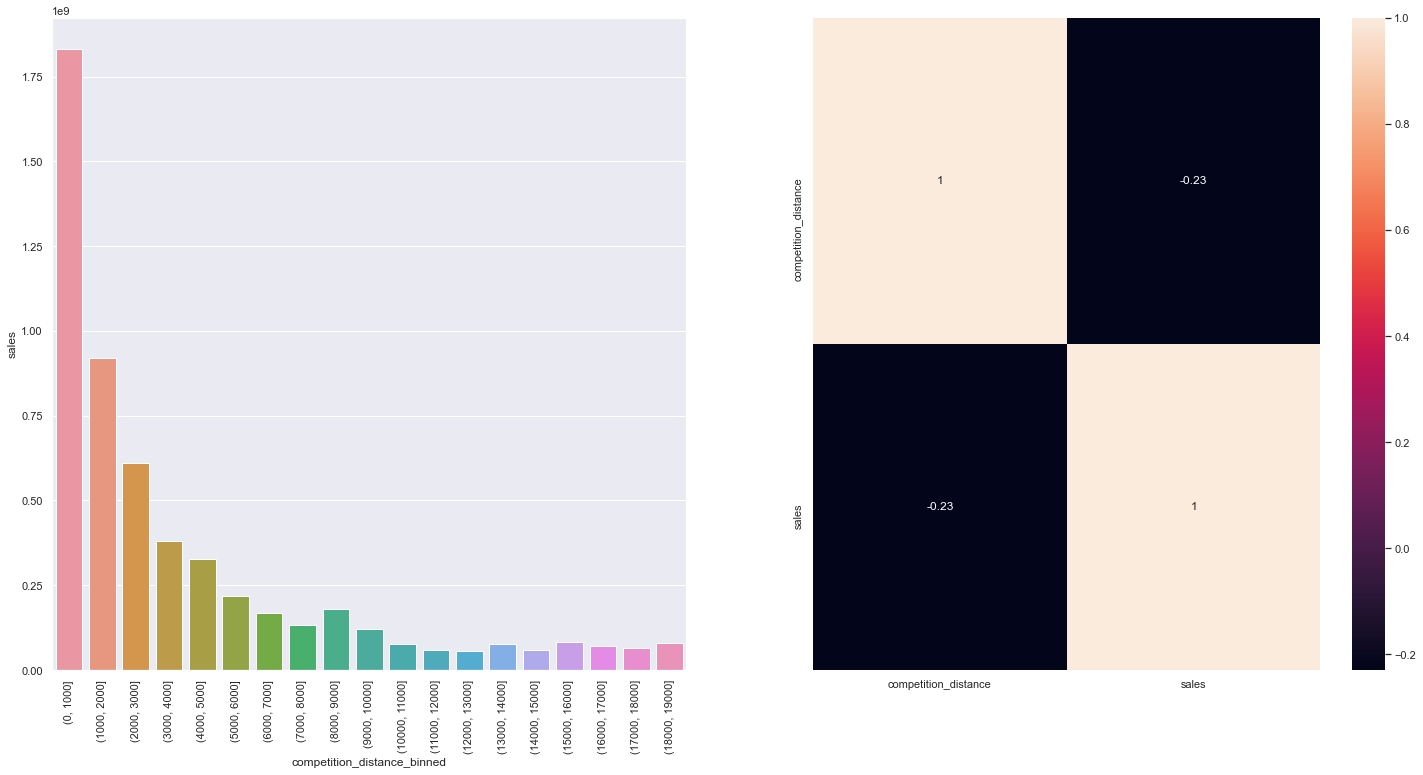

In [44]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


In [45]:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
559,16490.00,13005144,"(16000, 17000]"
315,4270.00,3809325,"(4000, 5000]"
287,3720.00,10148212,"(3000, 4000]"
365,5390.00,4275775,"(5000, 6000]"
25,270.00,25366502,"(0, 1000]"


### H3 Lojas com competidores a mais tempo deveriam vender mais.
***FALSO*** Lojas com competidores a MAIS TEMPO vendem MENOS

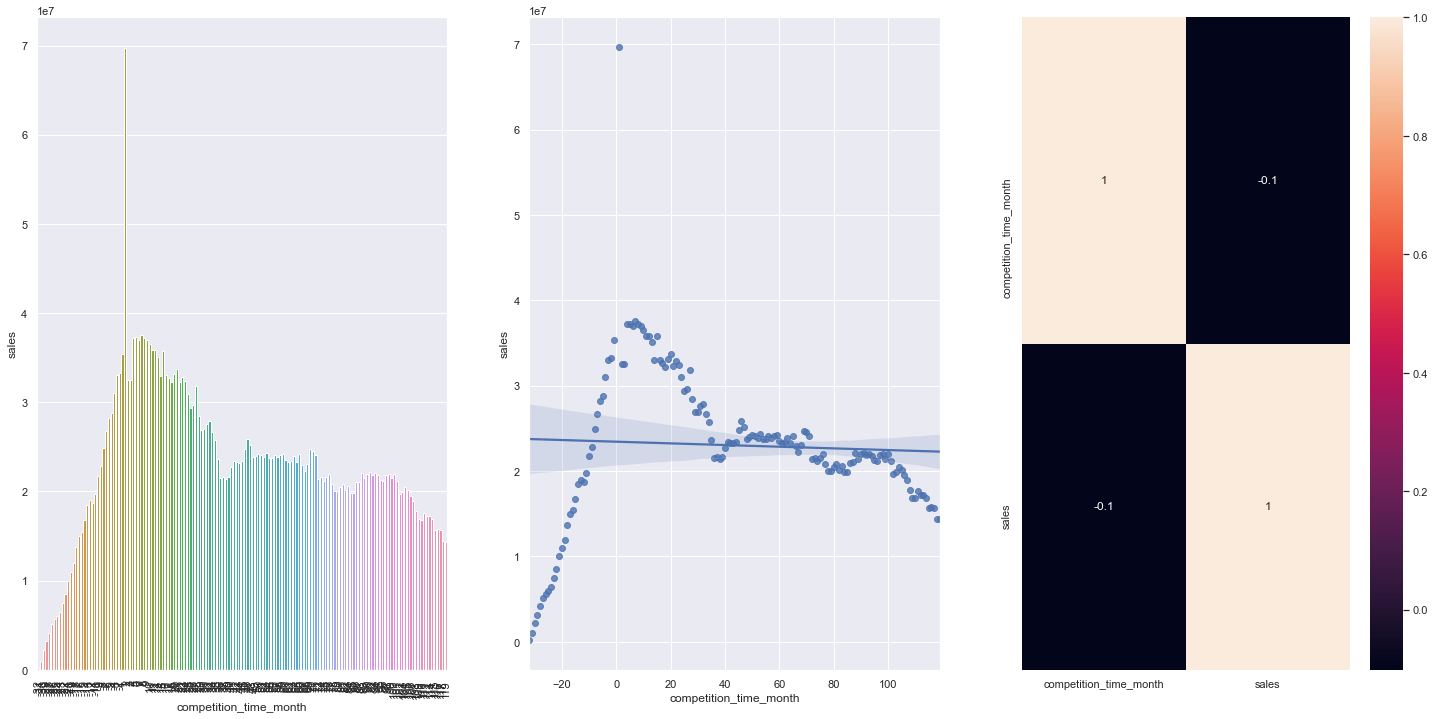

In [46]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

In [47]:
df4.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'year_of_week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_week'],
      dtype='object')

### H4 Lojas com promoçoes ativas por mais tempo deveriam vender mais
***FALSA** Lojas com promocoes ativas por MAIS TEMPO vendem MENOS, depois de um certo periodo de promocao

<AxesSubplot:>

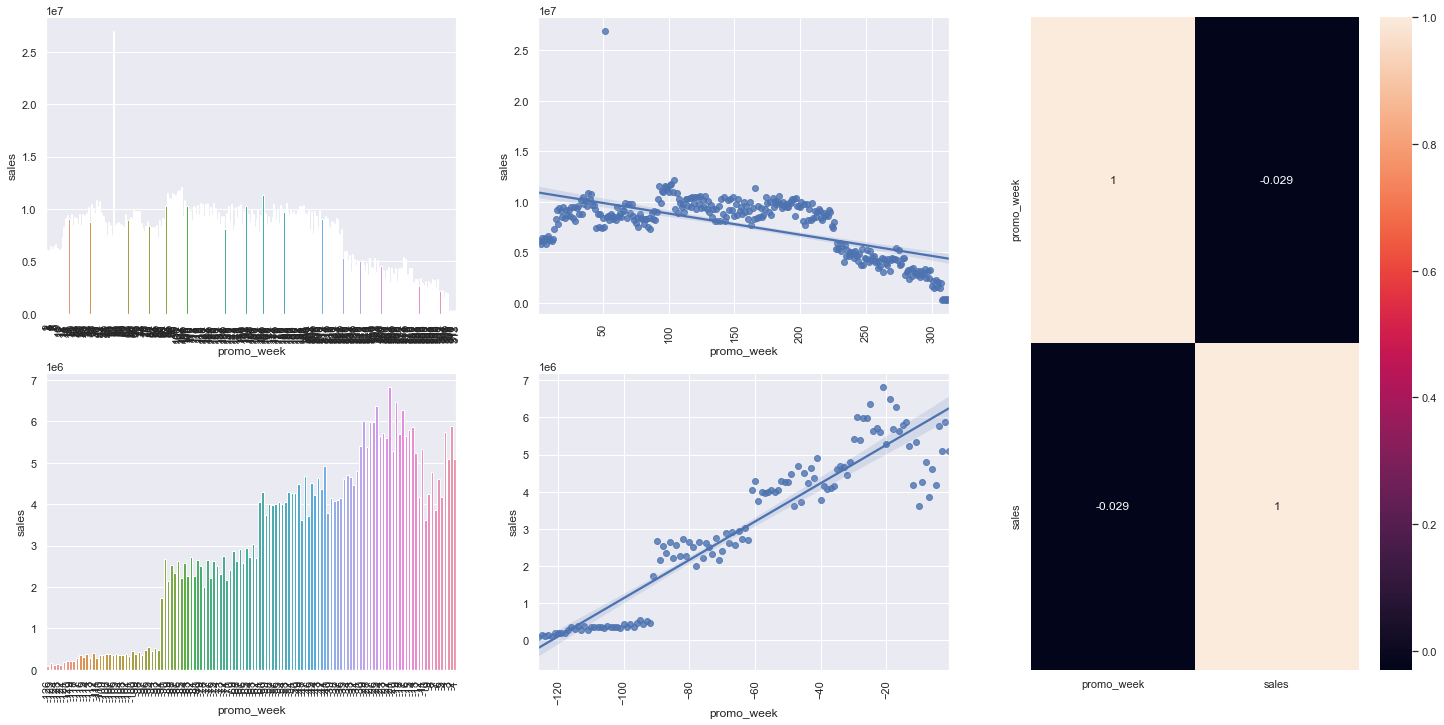

In [48]:
aux1 = df4[['promo_week','sales']].groupby('promo_week').sum().reset_index()

grid = GridSpec.GridSpec( 2,3 )

aux2 = aux1[aux1['promo_week'] > 0] # promo extendido
plt.subplot(grid[0,0])
sns.barplot(x='promo_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_week',y='sales',data=aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_week'] < 0] # promo regular
plt.subplot(grid[1,0])
sns.barplot(x='promo_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### <s>H5 Lojas com mais dias de promoção de veriam vender mais </s>

### H6 Lojas com mais promocoes consecutivas deveriam vender mais
***FALSA*** Lojas com MAIS promocoes consecutivas vendem MENOS

In [49]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


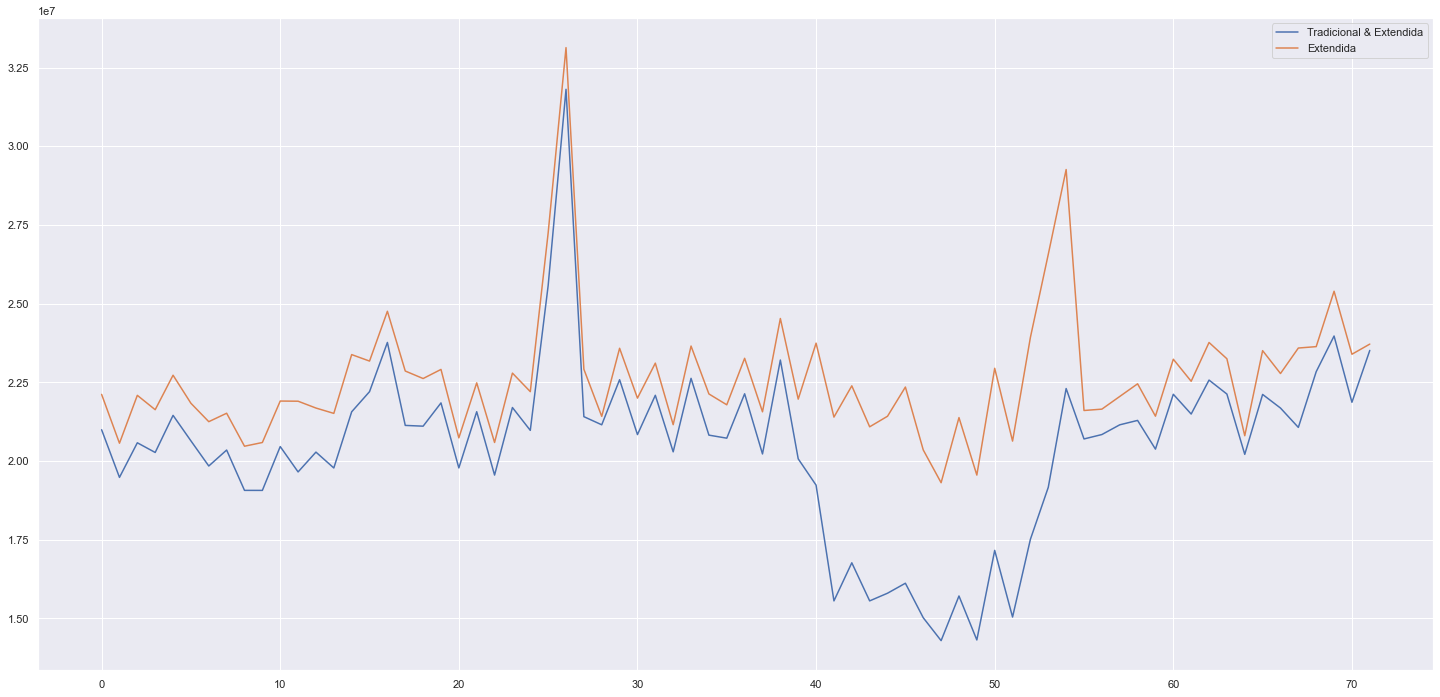

In [50]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida'])

### H7 Lojas abertas durante o feriado de Natal deveriam vender mais
***FALSA*** Lojas abertas durante o notal vendem MENOS

In [51]:
df4[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

,state_holiday,sales
0,christmas_holiday,691806
1,easter_holiday,1433744
2,public_holiday,5890305
3,regular_day,5865164768


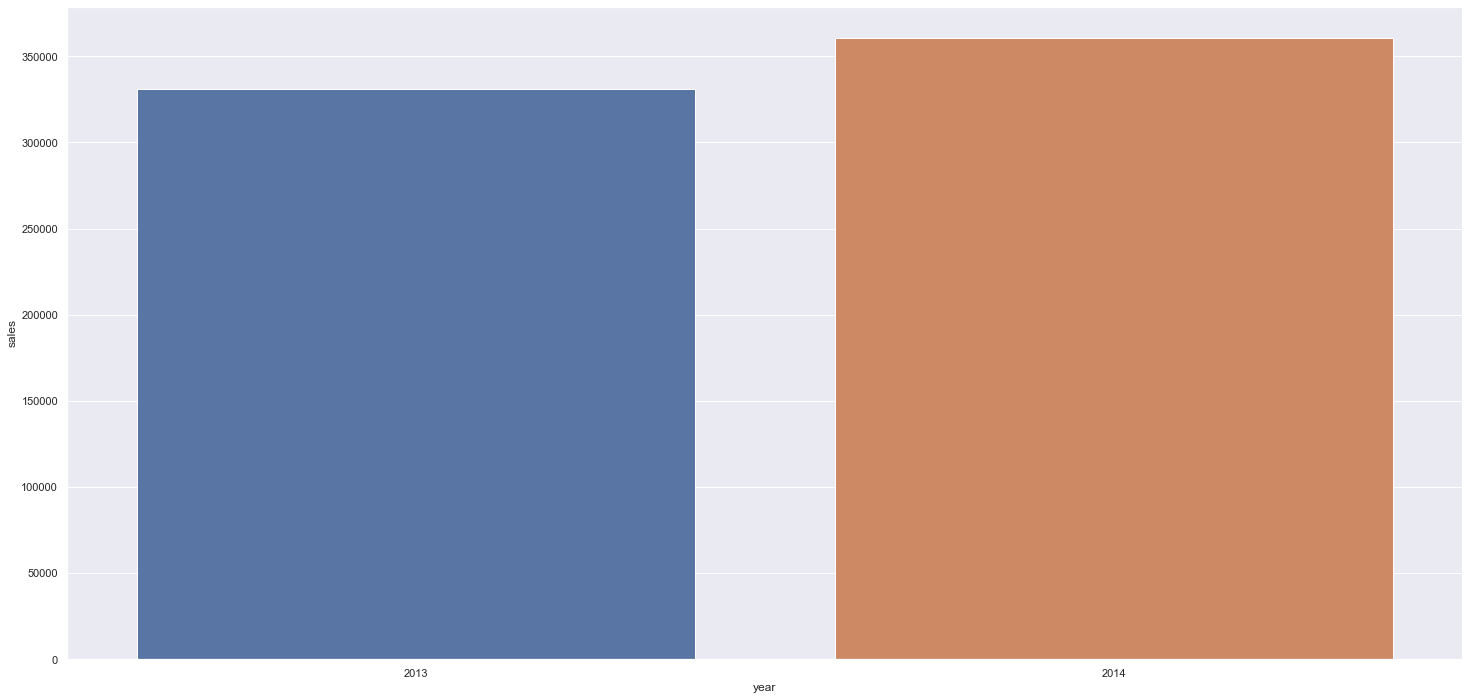

In [52]:
aux1 = df4[(df4['state_holiday'] == 'christmas_holiday')][['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1);

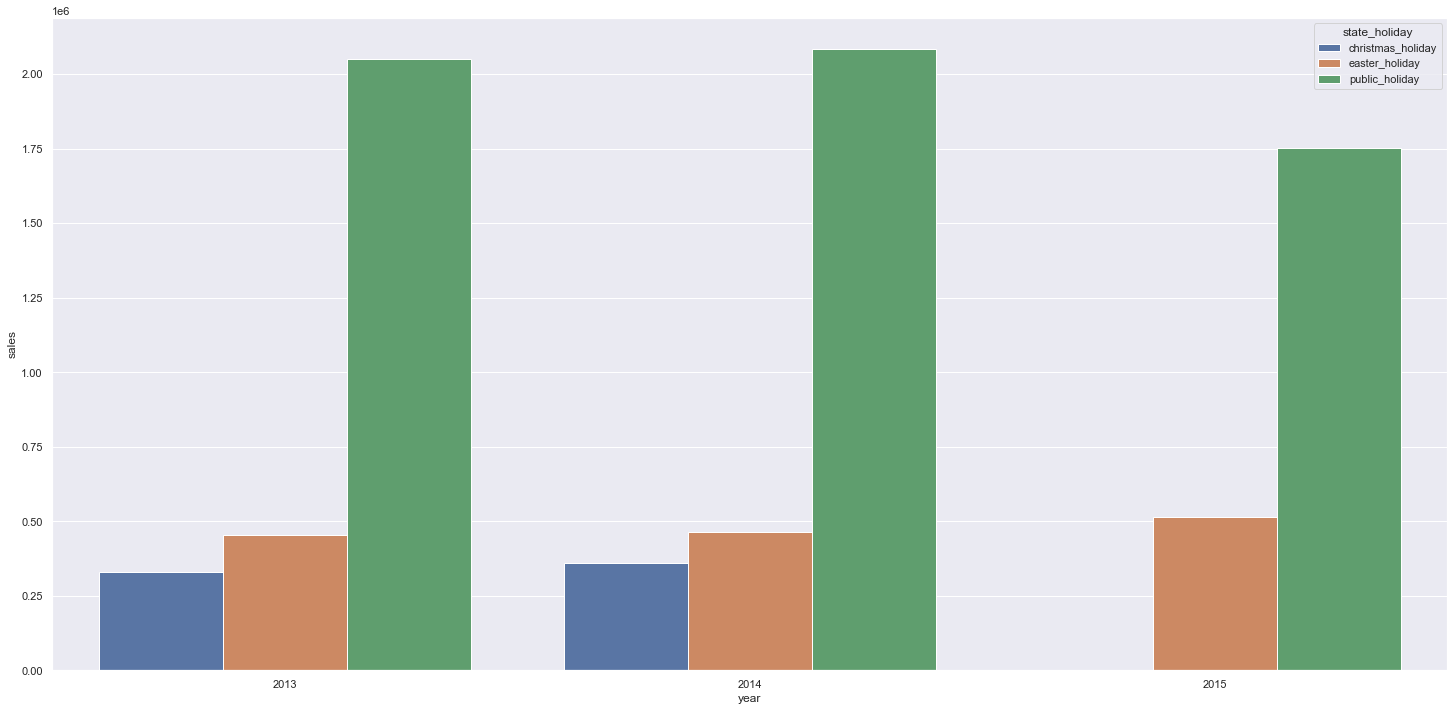

In [53]:
aux2 = df4[(df4['state_holiday'] != 'regular_day')][['year','sales','state_holiday']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8. Lojas deveriam vender mais ao longos dos anos.
***FALSO*** Lojas vendem MENOS ao longo dos anos

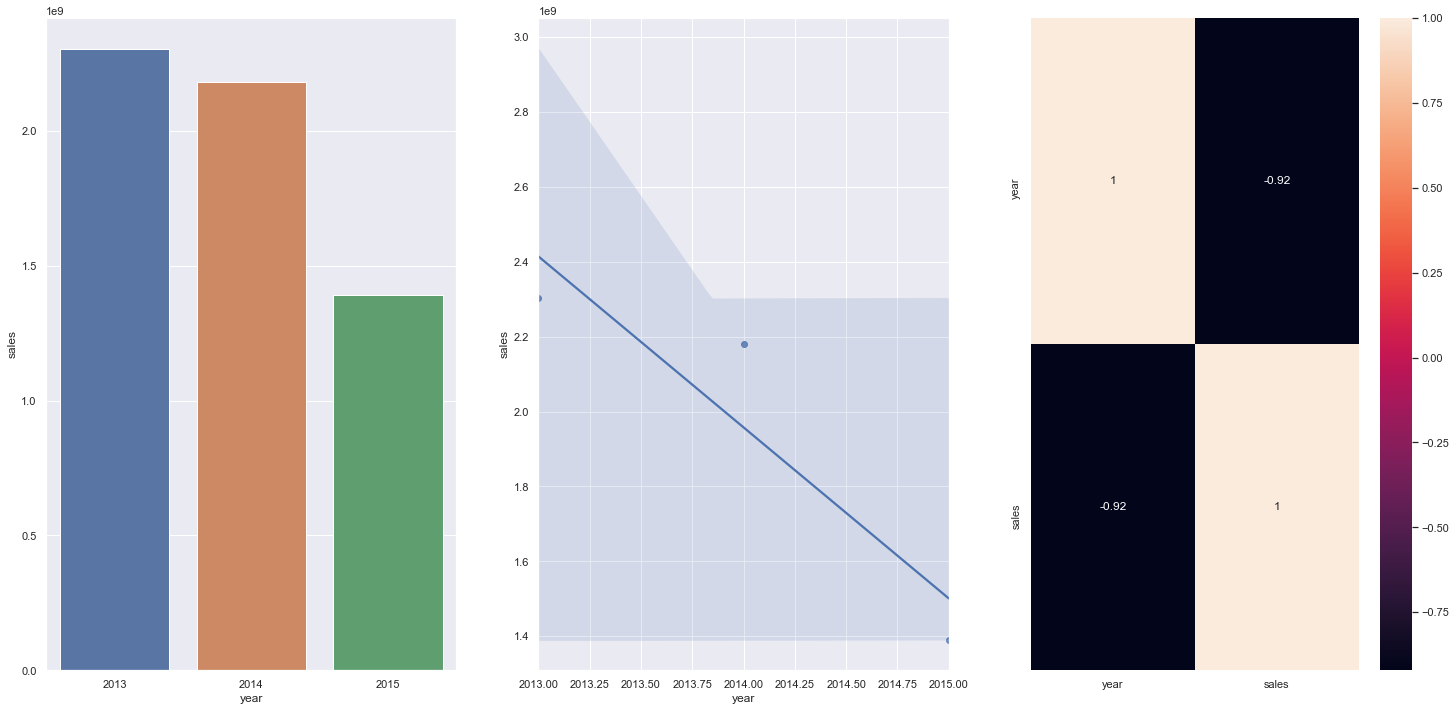

In [54]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
***FALSA*** Lojas vendem MENOS no segundo semestre do ano

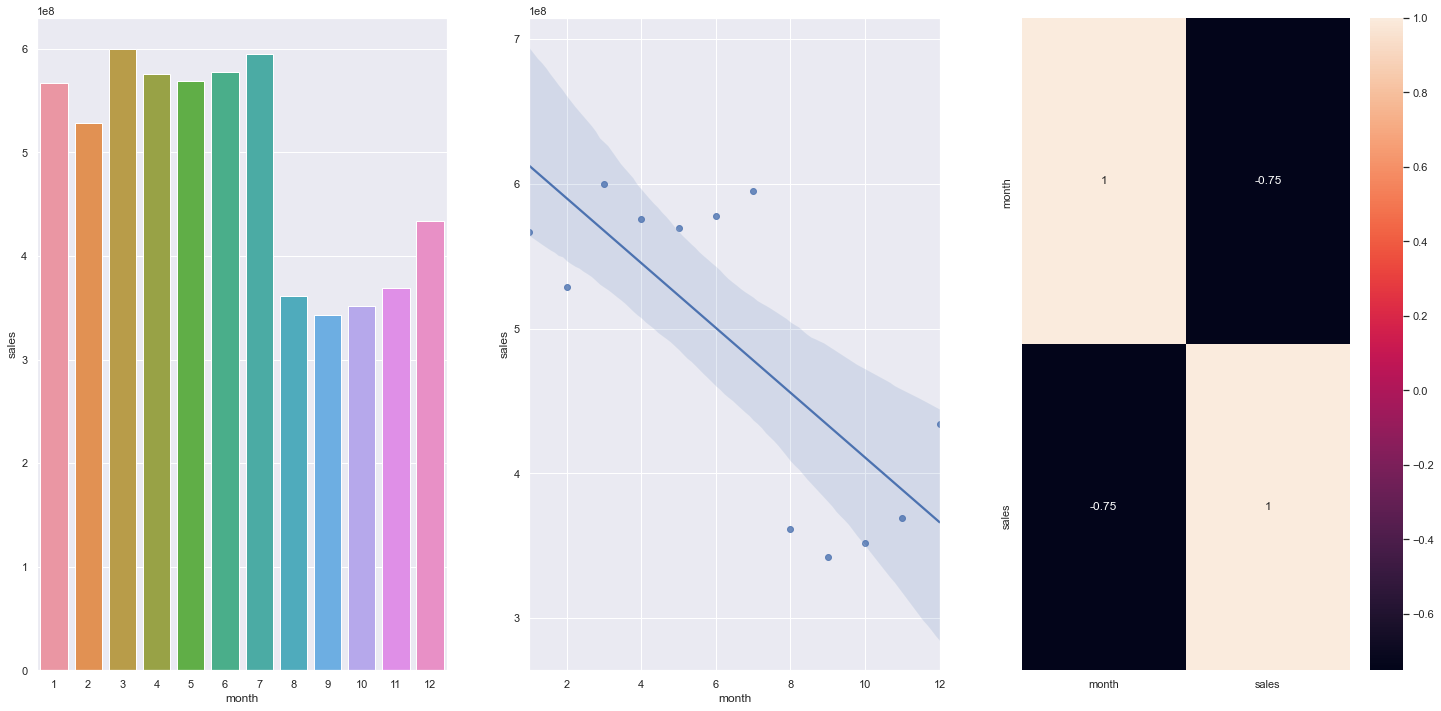

In [55]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mes.
***VERDADEIRA*** Lojas vendem MAIS depois do dia 10 de cada mes

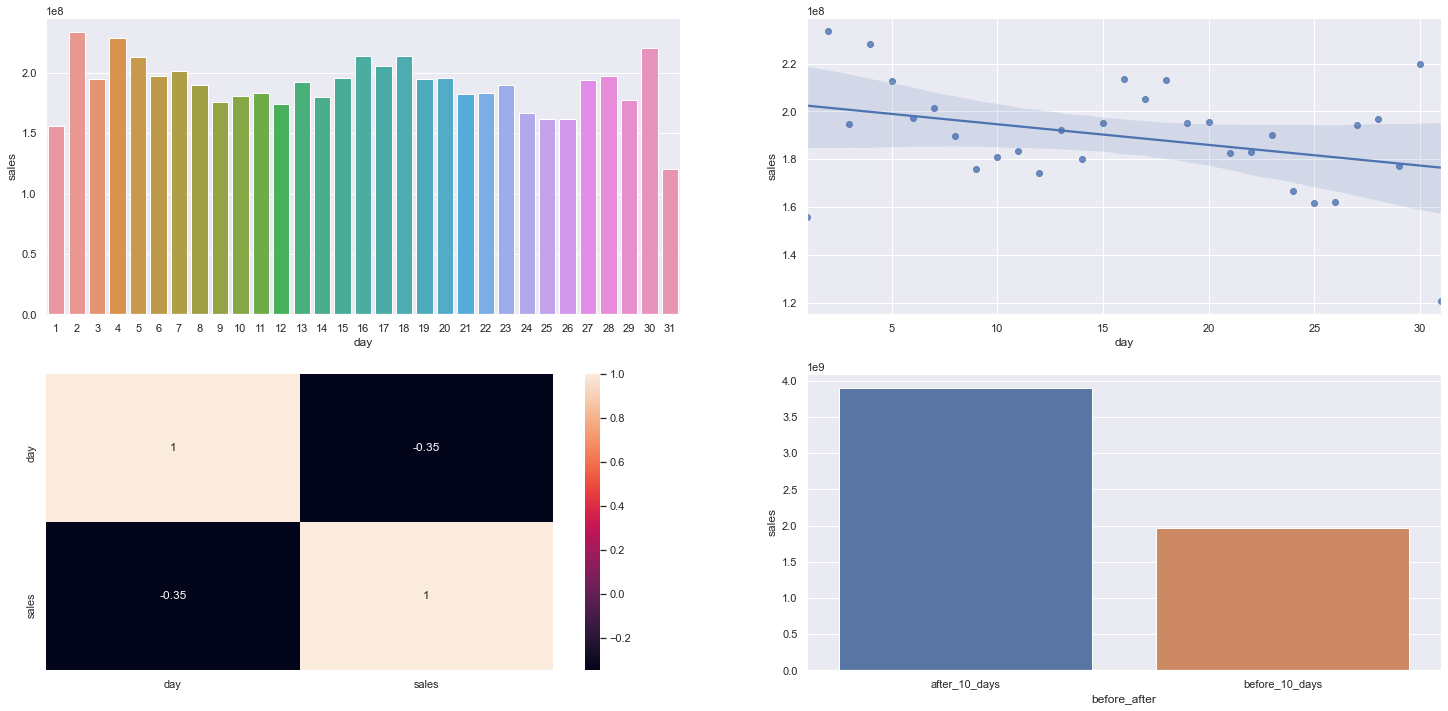

In [56]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
***FALSA*** Lojas vendem MENOS aos finais de semana

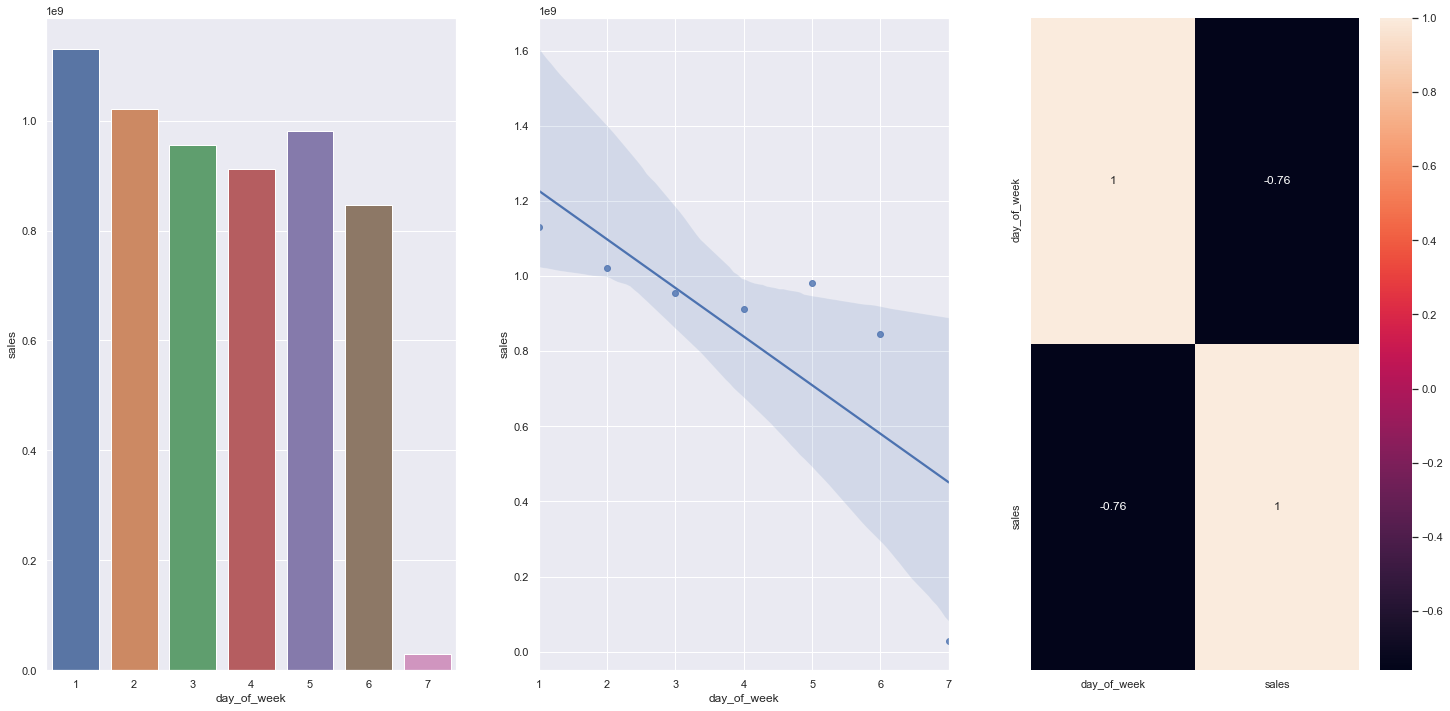

In [57]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA*** Lojas vendem MENOS durante os feriados escolares, exceto os meses Julho e Agosto

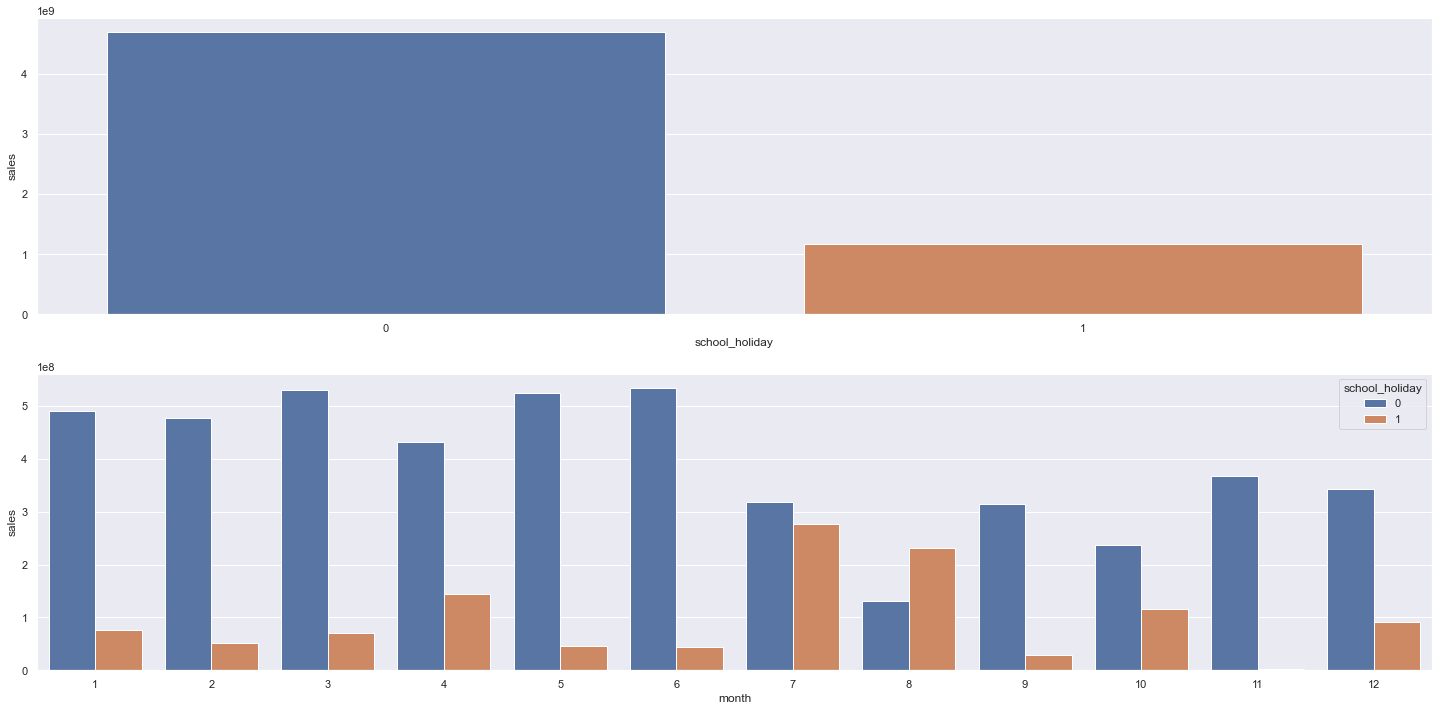

In [58]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

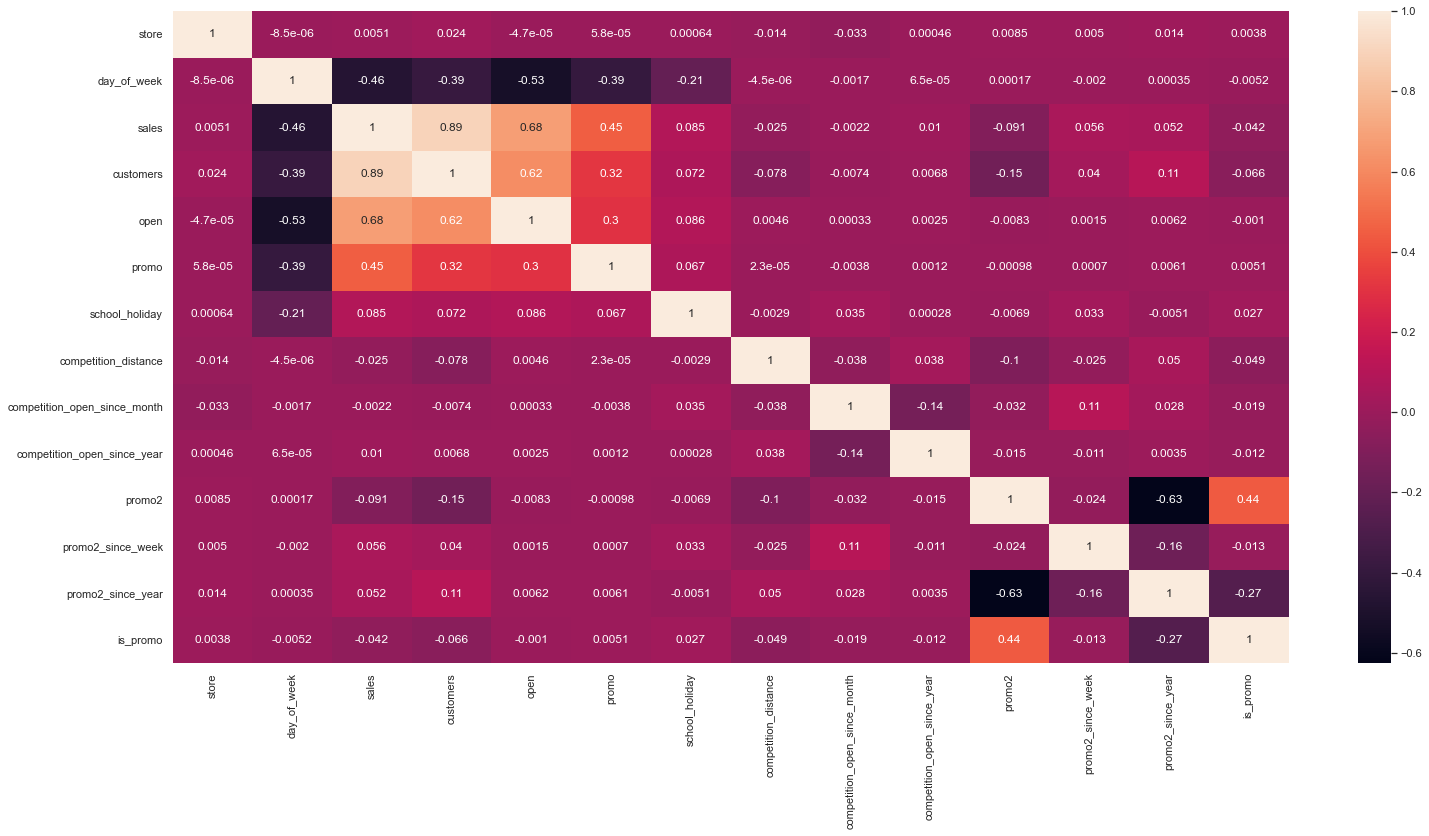

In [59]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### 4.3.2 Categorical Attributes

In [60]:
a = df4.select_dtypes(include='object')

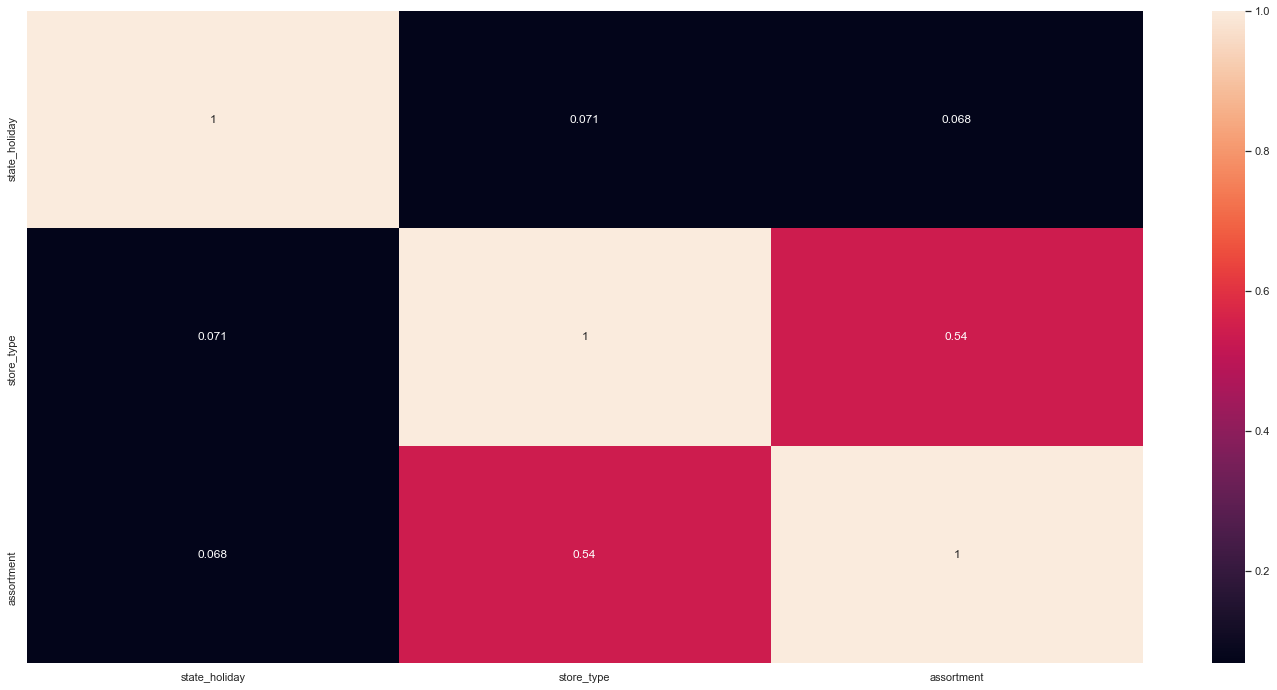

In [61]:
# Calculate cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d,annot=True);

# 5.0 Data Preparation

In [88]:
df5 = df4.copy()

## 5.1 <s>Normalizacao </s>

## 5.2 Rescaling

In [89]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# promo time week
df5['promo_week'] = mms.fit_transform( df5[['promo_week']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)

## 5.3 Transforming

### 5.3.1 Enconding

In [90]:
# state_holiday
df5 = pd.get_dummies( df5,prefix=['state_holiday'],columns=['state_holiday'] ) # One Hot Enconding

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] ) # Label Enconding

# assortment
assortment_dict ={'basic':1, 'extra':2,'extented':3}
df5['assortment'] = df5['assortment'].map(assortment_dict) # Ordinal Enconding

In [ ]:
# day of week
# day
# week of year
# month